In [1]:
from transformers import AutoTokenizer, LongformerForSequenceClassification, pipeline
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
import json
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
wording_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-wording-global', num_labels=1)
content_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-content-global', num_labels=1)

In [3]:
with open('../data/source_dict.txt', 'r') as data:
    source_dict = json.loads(data.read())

df = pd.read_csv('../data/PCA_scores_itell.csv', index_col=[0]).reset_index()
df['content_pca'] = StandardScaler().fit_transform(np.array(df['Content_pca']).reshape(-1,1))
df['wording_pca'] = StandardScaler().fit_transform(np.array(df['Wording_pca']).reshape(-1,1))
df['chapter_section'] = df['section'].apply(lambda x: '01-'+str(x))
scores_df = pd.read_csv('../data/qualtrics_survey.csv')[['summary', 'containment', 'similarity','word_count']]

In [4]:
df = df.merge(scores_df, on='summary', how='left')

In [5]:
def inference(row, model):
    source = row['chapter_section']
    combined = row['summary'] + '</s>' + source
    context = tokenizer(combined)
    sep_index = context['input_ids'].index(2)
    context['global_attention_mask'] = [1]*(sep_index + 1) + [0]*(len(context['input_ids'])-(sep_index + 1))
    inputs = {}
    for key in context:
        inputs[key] = torch.tensor([context[key]])
    return float(model(**inputs)['logits'][0][0])

In [6]:
df.loc[:,'pred_content'] = df.apply(lambda row: inference(row, content_model), axis=1)
df.loc[:,'pred_wording'] = df.apply(lambda row: inference(row, wording_model), axis=1)


In [8]:
df

,index,...1,id,section,summary,Details,Language,main_points,Organization,Voice,...,Content_pca,Wording_pca,content_pca,wording_pca,chapter_section,containment,similarity,word_count,pred_content,pred_wording
0,1,0,55895b93fdf99b6bd06017c4,3,"in this section, students will acquire the abi...",0.660288,0.425193,0.922787,1.209107,0.432930,...,2.651988,-0.072425,0.929284,-0.047182,01-3,0.1977,0.862697,146.0,-0.676942,-0.672231
1,2,1,55895b93fdf99b6bd06017c42,2,"upon completion of this section, you will have...",1.385426,2.059530,1.679473,1.209107,1.565918,...,4.925285,3.082666,1.725870,2.008227,01-2,0.0496,0.782269,165.0,-0.251616,0.599786
2,3,2,57a9f41a16a091000112f1cf,3,individuals learn how to think critically and ...,0.660288,0.425193,0.922787,1.209107,1.565918,...,3.467739,1.300965,1.215131,0.847524,01-3,0.1304,0.818854,106.0,-1.905528,-2.043753
3,4,3,57a9f41a16a091000112f1cf2,2,economics is a subject that concerns the well-...,2.110564,0.425193,0.922787,0.400845,0.432930,...,3.641325,-0.759120,1.275958,-0.494535,01-2,0.1702,0.840282,136.0,-1.090805,0.067035
4,5,4,589fc07f1521230001ebf494,4,the heritage foundation categorizes types of e...,-0.064850,0.425193,0.922787,-0.407416,-0.700057,...,0.007936,0.614270,0.002781,0.400171,01-4,NaN,NaN,NaN,-2.995368,-2.558675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,119,118,63dae36f736faa53f7c681272,2,microeconomics involve the smaller stakeholder...,0.660288,0.425193,0.166102,0.400845,0.432930,...,1.422384,1.300965,0.498418,0.847524,01-2,0.0000,0.629189,63.0,-2.099088,-2.338495
119,120,119,63e524df61b5e74ad715852b,3,economic theory differs from psychological or ...,-2.240264,0.425193,-1.347270,-0.407416,-1.833045,...,-5.180453,-0.072425,-1.815284,-0.047182,01-3,NaN,NaN,NaN,-1.912907,-2.306908
120,121,120,63e524df61b5e74ad715852b,4,markets in general have evolved from a one fac...,-0.064850,1.242362,0.166102,1.209107,-0.700057,...,0.378691,1.848468,0.132697,1.204199,01-4,NaN,NaN,NaN,-2.296701,-2.053565
121,122,121,63e563e181e6c9cc44348a12,4,this section was a learning experience. i was ...,0.660288,0.425193,0.166102,0.400845,-0.700057,...,0.606633,0.614270,0.212570,0.400171,01-4,0.0198,0.680008,141.0,-1.844563,-1.388255


In [15]:
df[['content_pca', 'wording_pca', 'pred_content', 'pred_wording']].corr()

,content_pca,wording_pca,pred_content,pred_wording
content_pca,1.000000,0.502628,0.704855,0.629923
wording_pca,0.502628,1.000000,0.303740,0.286698
pred_content,0.704855,0.303740,1.000000,0.883552
pred_wording,0.629923,0.286698,0.883552,1.000000


In [21]:
from scipy.stats import kendalltau, pearsonr, spearmanr

pearsonr(df['wording_pca'], df['pred_wording'])

PearsonRResult(statistic=0.2866978078653709, pvalue=0.0013047433211761073)

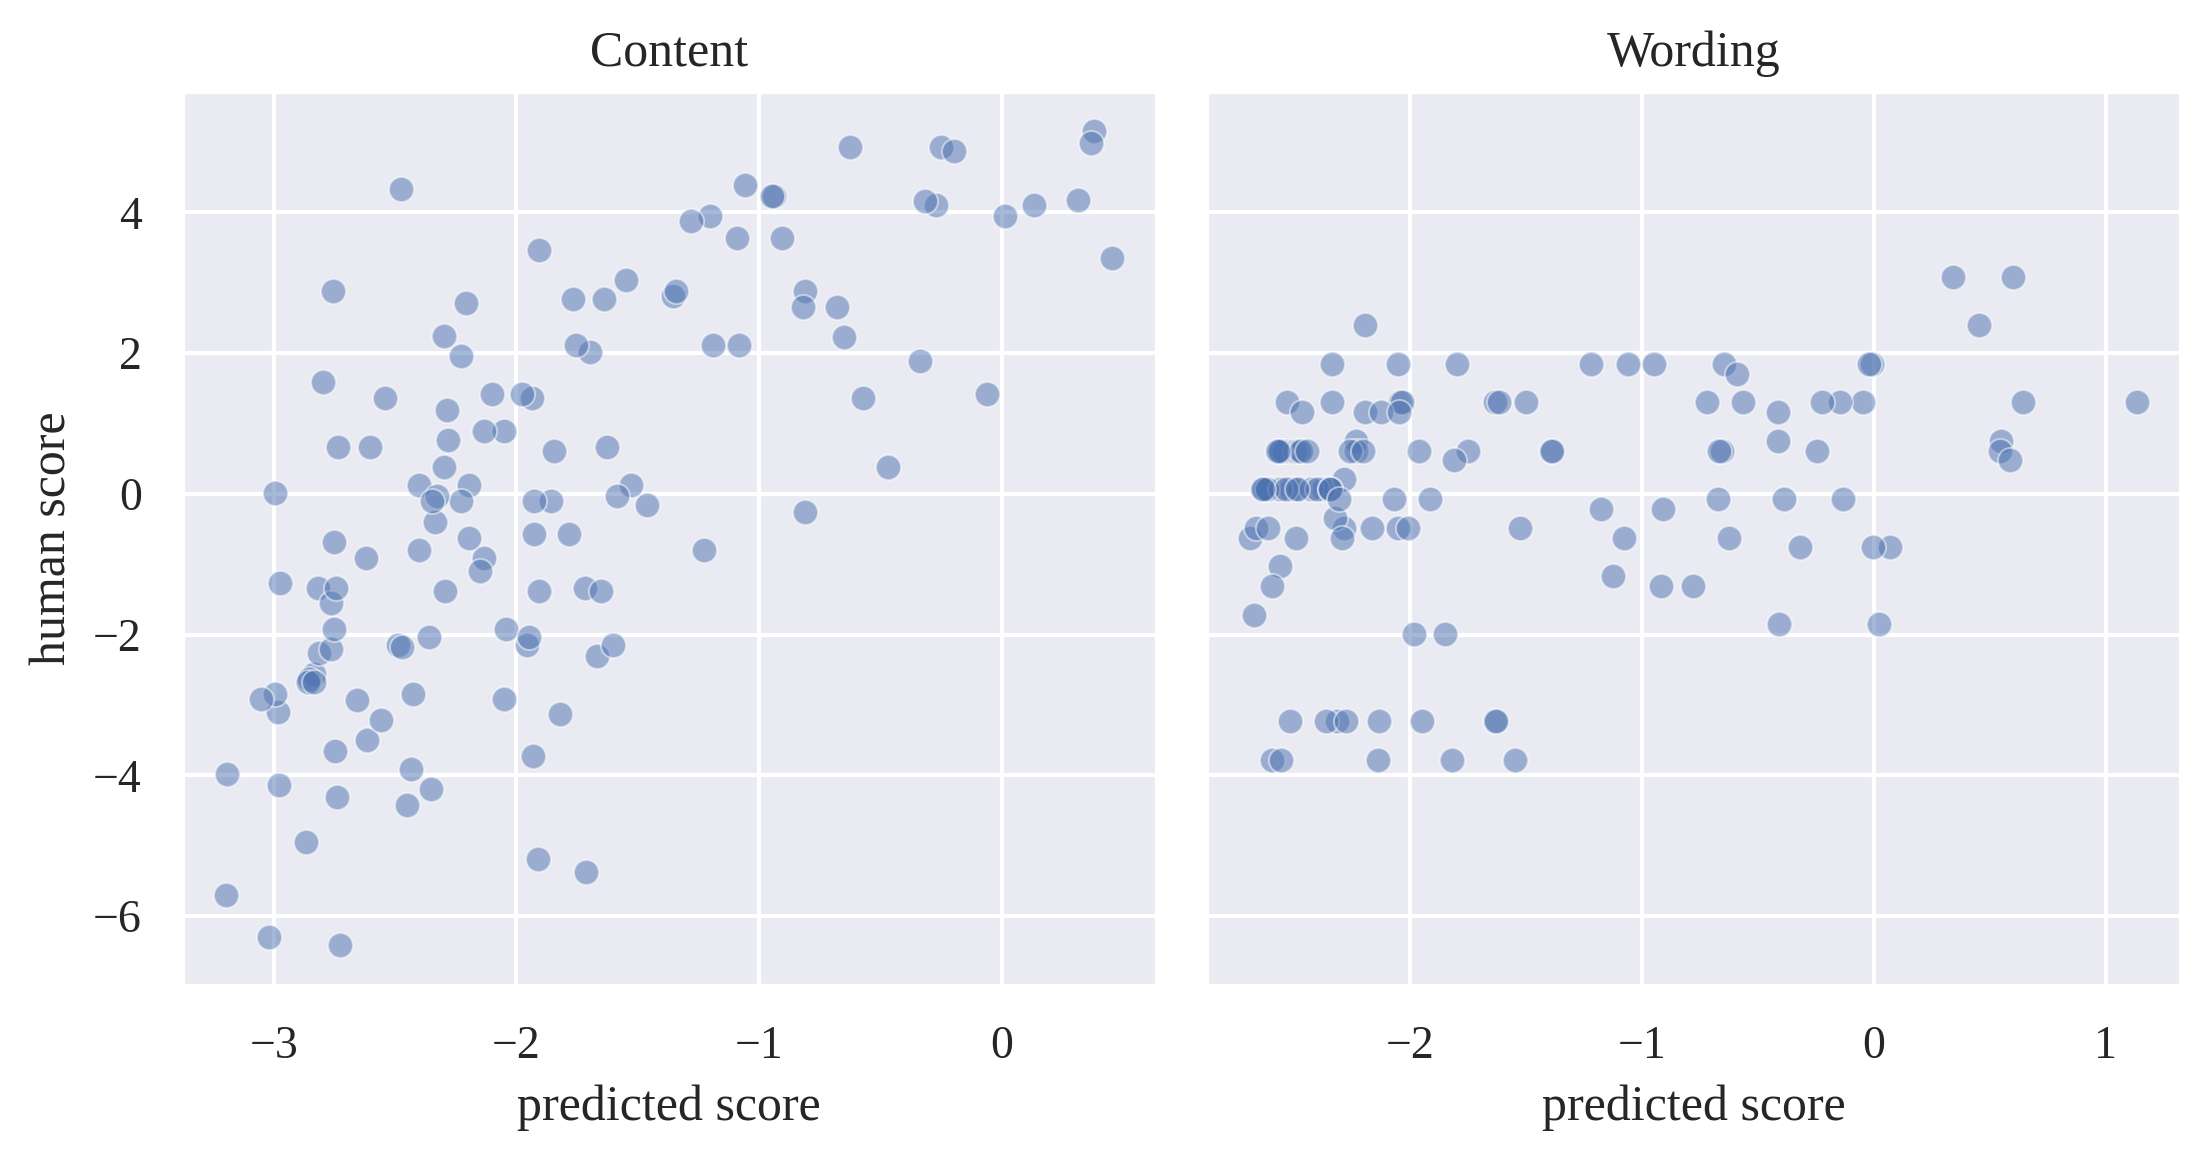

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,4),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })


fig, ax = plt.subplots(1,2, sharey=True)
plt.setp(ax, xticks=[-3, -2, -1, 0, 1, 2])
plt.rcParams["figure.figsize"] = [10.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(df, x='pred_content', y='Content_pca', alpha = 0.5, ax = ax[0])
sns.scatterplot(df, x='pred_wording', y= 'Wording_pca', alpha= 0.5, ax= ax[1])
ax[0].set(xlabel='predicted score', ylabel='human score', title='Content')
ax[1].set(xlabel='predicted score', ylabel='human score', title='Wording')
plt.show()

Text(0.5, 1.0, 'Covariance of Content and Wording Predictions')

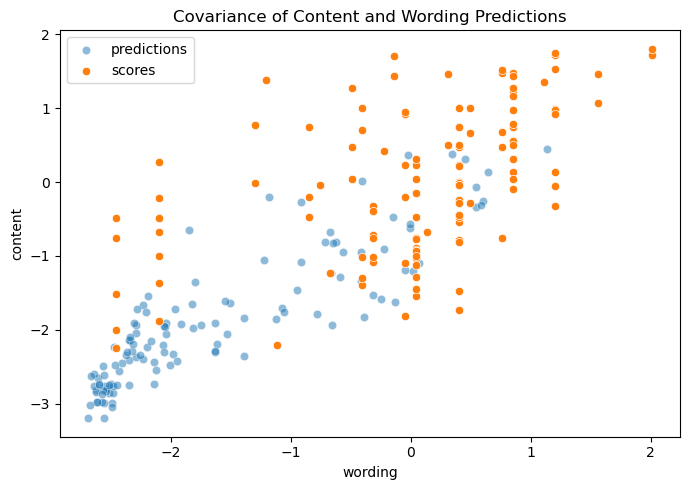

In [91]:
plt.rcParams["figure.figsize"] = [7, 5]
sns.scatterplot(df, x='pred_wording', y= 'pred_content', alpha= 0.5)
sns.scatterplot(df, x='wording_pca', y='content_pca')
plt.legend(['predictions', 'scores'])
plt.xlabel('wording')
plt.ylabel('content')
plt.title('Covariance of Content and Wording Predictions')

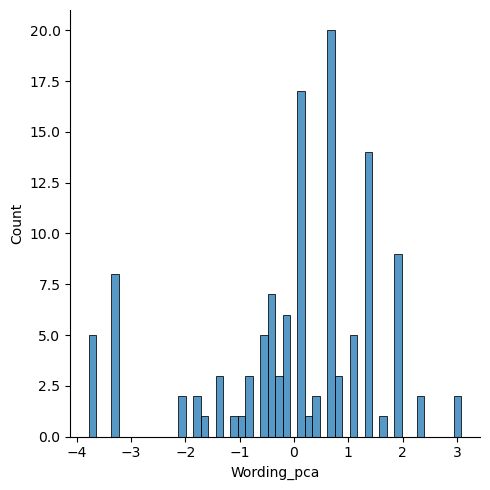

In [102]:
plt.rcParams["figure.figsize"] = [15, 5]

sns.displot(df, x='Wording_pca', kind='hist', bins=50)

In [77]:
df1 = df[(df['pred_content'] < 2) & (df['wording_pca'] < 0.1) & (df['wording_pca'] > 0) ] 
print(df1['summary'].iloc[2])

economists in this course will primarily utilize graphs to solve economic dilemmas that require a model, an "applied or theorical representation" of a concept less abstract than a theory for analysis.  circular flow diagrams are a nice example of how information.can be interpreted, as they include necessary features for comprehension in a clear, detailed fashion.


In [78]:
df1.iloc[2]

index                                                             19
...1                                                              18
id                                          5d2eac390aca250001e9c3e1
section                                                            3
summary            economists in this course will primarily utili...
Details                                                    -0.789988
Language                                                   -0.391975
main_points                                                -0.590584
Organization                                               -0.407416
Voice                                                        0.43293
Wording                                                     0.310746
Content_pca                                                 -1.33001
Wording_pca                                                 0.066767
content_pca                                                -0.466049
wording_pca                       